<a href="https://colab.research.google.com/github/missryta/411w8/blob/master/StackEnsemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/securycore/MLRD-Machine-Learning-Ransomware-Detection/master/data_file.csv'
data = pd.read_csv(url)

# Display the first few rows
print(data.head())

                                            FileName  \
0           0124e21d-018c-4ce0-92a3-b9e205a76bc0.dll   
1       05c8318f98a5d301d80000009c316005.vertdll.dll   
2           06054fba-5619-4a86-a861-ffb0464bef5d.dll   
3        075822ac99a5d301660400009c316005.adhapi.dll   
4  090607dd9ba5d301ca0900009c316005.SensorsNative...   

                            md5Hash  Machine  DebugSize  DebugRVA  \
0  79755c51e413ed3c6be4635fd729a6e1      332          0         0   
1  95e19f3657d34a432eada93221b0ea16    34404         84    121728   
2  85c32641d77a54e19ba8ea4ab305c791      332          0         0   
3  62e3b959d982ef534b66f819fe15f085    34404         84     19904   
4  ae38c5f7d313ad0ff3bfb8826476767f    34404         84     97728   

   MajorImageVersion  MajorOSVersion  ExportRVA  ExportSize  IatVRA  \
0                  0               4          0           0    8192   
1                 10              10     126576        4930       0   
2                  0               

In [ ]:
# Select features and target variable
X = data[['Machine', 'DebugSize', 'DebugRVA', 'MajorImageVersion', 'MajorOSVersion',
        'ExportRVA', 'ExportSize', 'IatVRA', 'MajorLinkerVersion', 'MinorLinkerVersion',
         'NumberOfSections', 'SizeOfStackReserve', 'DllCharacteristics', 'ResourceSize', 'BitcoinAddresses']]
y = data['Benign']

In [ ]:
# Drop the 'FileName' and 'md5Hash' columns
data = data.drop(['FileName', 'md5Hash'], axis=1)

# Verify that the columns have been dropped
print(data.head())

   Machine  DebugSize  DebugRVA  MajorImageVersion  MajorOSVersion  ExportRVA  \
0      332          0         0                  0               4          0   
1    34404         84    121728                 10              10     126576   
2      332          0         0                  0               4          0   
3    34404         84     19904                 10              10      21312   
4    34404         84     97728                 10              10     105792   

   ExportSize  IatVRA  MajorLinkerVersion  MinorLinkerVersion  \
0           0    8192                   8                   0   
1        4930       0                  14                  10   
2           0    8192                   8                   0   
3         252   18160                  14                  10   
4        1852   70592                  14                  10   

   NumberOfSections  SizeOfStackReserve  DllCharacteristics  ResourceSize  \
0                 3             1048576      

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = data.iloc[:, :-1]  # Features (all columns except the last one)
y = data.iloc[:, -1]   # Target (last column)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Initialize the models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
svm = SVC(probability=True, random_state=42)

# Train the models
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
svm.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:37:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.ensemble import VotingClassifier

# Initialize the Voting Classifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf), ('xgb', xgb), ('svm', svm)],
    voting='soft'  # 'soft' uses predicted probabilities; 'hard' uses predicted class labels
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:37:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importanc...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('svm', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_pred = ensemble_model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.9957324229168889
Precision: 0.9957351265311842
Recall: 0.9957324229168889
F1 Score: 0.9957315077851242


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_pred = ensemble_model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Round the results to one decimal place
accuracy = round(accuracy * 100, 1)
precision = round(precision * 100, 1)
recall = round(recall * 100, 1)
f1 = round(f1 * 100, 1)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 99.6
Precision: 99.6
Recall: 99.6
F1 Score: 99.6


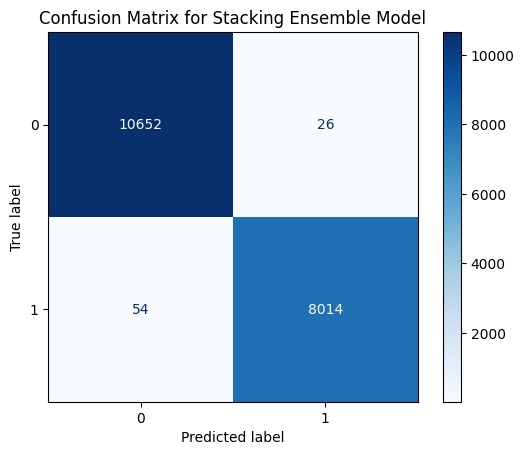

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions using your ensemble model
y_pred = ensemble_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Add a title
plt.title('Confusion Matrix for Stacking Ensemble Model')

# Show the plot
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Define your base models
estimators = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True))
]

# Define your stacking ensemble model
ensemble_model = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier()  # You can choose another model for the final estimator
)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(ensemble_model, X, y, cv=10)

# Print the results
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Accuracy: {cv_scores.mean():.2f}')
print(f'Standard Deviation: {cv_scores.std():.2f}')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:32:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:51:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:51:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:51:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:51:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e